In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

In [2]:
def get_vocab(data_location, lowering = False):
    
    with open(data_location, 'r') as fopen:
        data = fopen.read()
    if lowering:
        data = data.lower()

    vocab = list(set(data))
    
    return data, vocab

def embed_to_onehot(data, vocab):
    
    onehot = np.zeros((len(data), len(vocab)), dtype = np.float32)

    for i in xrange(len(data)):
        onehot[i, vocab.index(data[i])] = 1.0
    
    return onehot

In [3]:
class Model:
    
    def __init__(self, num_layers, size_layer, dimension_input, learning_rate, optimizer):
        
        def lstm_cell():
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
        
        self.rnn_cells = tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in xrange(num_layers)], state_is_tuple = False)
        
        self.X = tf.placeholder(tf.float32, [None, None, dimension_input])
        self.Y = tf.placeholder(tf.float32, [None, None, dimension_input])
        
        self.hidden_layer = tf.placeholder(tf.float32, (None, num_layers * 2 * size_layer))
        
        self.outputs, self.last_state = tf.nn.dynamic_rnn(self.rnn_cells, self.X, initial_state = self.hidden_layer, dtype = tf.float32)

        self.rnn_W = tf.Variable(tf.random_normal((size_layer, dimension_input)))
        self.rnn_B = tf.Variable(tf.random_normal([dimension_input]))
        
        self.logits = tf.matmul(tf.reshape(self.outputs, [-1, size_layer]), self.rnn_W) + self.rnn_B
        
        seq_shape = tf.shape(self.outputs)
        
        self.final_outputs = tf.reshape(tf.nn.softmax(self.logits), (seq_shape[0], seq_shape[1], dimension_input))
        
        y_batch_long = tf.reshape(self.Y, [-1, dimension_input])
        
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = y_batch_long))
        
        if optimizer == 0:
            self.optimizer = tf.train.AdagradOptimizer(learning_rate = learning_rate).minimize(self.cost)
        elif optimizer == 1:
            self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        elif optimizer == 2:
            self.optimizer = tf.train.RMSPropOptimizer(learning_rate, 0.9).minimize(self.cost)
        else:
            exit(0)
        
        self.correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(y_batch_long, 1))
        
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

In [4]:
text, text_vocab = get_vocab('input.txt', lowering = False)
onehot = embed_to_onehot(text, text_vocab)

In [5]:
learning_rate = 0.01
batch_size = 100
sequence = 64
epoch = 2500
num_layers = 2
size_layer = 512
possible_batch_id = range(len(text) - batch_size - 1)

In [6]:
split_text = text.split()
tag = split_text[random.randint(0, len(split_text) - 1)]
print tag

mercy;


In [7]:
def train():

    LOST, ACCURACY = [], []
    
    for i in xrange(epoch):
        last_time = time.time()
        init_value = np.zeros((sequence, num_layers * 2 * size_layer))
        batch_x = np.zeros((sequence, batch_size, len(text_vocab)))
        batch_y = np.zeros((sequence, batch_size, len(text_vocab)))
        batch_id = random.sample(possible_batch_id, sequence)
        
        for n in xrange(batch_size):
            id1 = [k + n for k in batch_id]
            id2 = [k + n + 1 for k in batch_id]
            batch_x[:, n, :] = onehot[id1, :]
            batch_y[:, n, :] = onehot[id2, :]

        last_state, _, loss = sess.run([model.last_state, model.optimizer, model.cost], feed_dict = {model.X: batch_x, model.Y: batch_y, model.hidden_layer: init_value})
        accuracy = sess.run(model.accuracy, feed_dict = {model.X: batch_x, model.Y: batch_y, model.hidden_layer: init_value})

        ACCURACY.append(accuracy); LOST.append(loss)
        if (i + 1) % 100 == 0:
            print 'epoch: ' + str(i + 1) + ', accuracy: ' + str(accuracy) + ', loss: ' + str(loss) + ', s / epoch: ' + str((time.time() - last_time))
            
    sns.set()
    plt.figure(figsize = (15, 5))
    plt.subplot(1, 2, 1)
    EPOCH = [i for i in xrange(len(LOST))]
    plt.plot(EPOCH, LOST)
    plt.xlabel('epoch'); plt.ylabel('loss')
    plt.subplot(1, 2, 2)
    plt.plot(EPOCH, ACCURACY)
    plt.xlabel('epoch'); plt.ylabel('accuracy')
    plt.show()

In [8]:
def generate():
    sentence_generated = tag
    onehot = embed_to_onehot(tag, text_vocab)
    init_value = np.zeros((sequence, num_layers * 2 * size_layer))
    for i in xrange(len(tag)):
        batch_x = np.zeros((sequence, 1, len(text_vocab)))
        batch_x[:, 0, :] = onehot[i, :]
        last_state, prob = sess.run([model.last_state, model.final_outputs], feed_dict = {model.X: batch_x, model.hidden_layer: init_value})
        init_value = last_state
        
    for i in xrange(1000):
        char = np.random.choice(range(len(text_vocab)), p = prob[0][0])
        element = text_vocab[char]
        sentence_generated += element
        onehot = embed_to_onehot(element, text_vocab)
        batch_x = np.zeros((sequence, 1, len(text_vocab)))
        batch_x[:, 0, :] = onehot[0, :]
        last_state, prob = sess.run([model.last_state, model.final_outputs], feed_dict = {model.X: batch_x, model.hidden_layer: init_value})
        init_value = last_state
    
    print sentence_generated

epoch: 100, accuracy: 0.152969, loss: 3.3229, s / epoch: 0.284369945526
epoch: 200, accuracy: 0.155, loss: 3.22879, s / epoch: 0.285254955292
epoch: 300, accuracy: 0.157187, loss: 3.20824, s / epoch: 0.285446166992
epoch: 400, accuracy: 0.165625, loss: 3.18613, s / epoch: 0.284250974655
epoch: 500, accuracy: 0.169531, loss: 3.12672, s / epoch: 0.286031007767
epoch: 600, accuracy: 0.177969, loss: 3.07835, s / epoch: 0.285798072815
epoch: 700, accuracy: 0.176406, loss: 3.10207, s / epoch: 0.284873008728
epoch: 800, accuracy: 0.18625, loss: 3.02037, s / epoch: 0.285813093185
epoch: 900, accuracy: 0.201562, loss: 3.01817, s / epoch: 0.286170005798
epoch: 1000, accuracy: 0.206406, loss: 2.99092, s / epoch: 0.284572124481
epoch: 1100, accuracy: 0.211406, loss: 2.96609, s / epoch: 0.286201000214
epoch: 1200, accuracy: 0.204844, loss: 2.96659, s / epoch: 0.286088943481
epoch: 1300, accuracy: 0.21625, loss: 2.93587, s / epoch: 0.284380912781
epoch: 1400, accuracy: 0.217656, loss: 2.92371, s / e

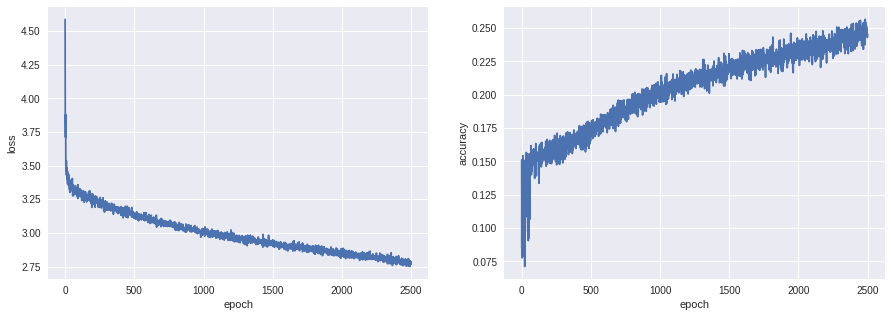

mercy;?i tghays, 
nolctls hino y uad btihh tarau LasI ke rnad pyar
haouTed wah eot roel;?:,I y wad haelmen tohe wrteh te,ad satne at'rus, usost  oav heee ra uhh ve waTy tEhoa mst mhae nca rate sht ae! nhb!tt
hceETld: f.feI
GyM,r sd sovy see mp srod ty
ilde !thyee
GoB:n th ael eft owo
.
NICDUIBNY:tb: toe ma! ein bsbb tuea ttaainrgl me paeges pcea tlhu tlemss
oadnr old utdhe aonds a-a crefahur isedgd ot: eno treeo dv-oit tha fodur
sa nep ntoci
sadd,n hbpanse bgtthbeeese
doer itehd ovree nrhou gsaley othi hfirs.

OMCxGEuCNS
tCoLst ontg,tbi: nth oike;!A 
hay bvaef,d hifn thgie,r-weed
dLann gghes eotlo uw febher
spydn,aLtKesar, dy haecst; ho pdest Lo mahuett h soe aad.

oMtPeScle
tbdp intlg etom 
ey eatcr !one trade;
 hl uliss to: ke ersw
ereBti pnuet teo timy hosews rontume asdet hvscein shrle iunso'qd tahleekn
petbeldB hcacIIr
ALNtmSD alhne gaty ot iork obkngte i'dl ' aou smKgeWI sy atrardes WYuty tinrtA,s
 oIr e lekw': tih atetda b i uiln owdt heorpam
h ait hi-l ih aynpmbnte
ers uest arn

In [9]:
sess = tf.InteractiveSession()
model = Model(num_layers, size_layer, len(text_vocab), learning_rate, 0)
sess.run(tf.global_variables_initializer())
train()
generate()

epoch: 100, accuracy: 0.149531, loss: 3.27292, s / epoch: 0.28710603714
epoch: 200, accuracy: 0.305, loss: 2.56375, s / epoch: 0.287534952164
epoch: 300, accuracy: 0.352812, loss: 2.29384, s / epoch: 0.286577939987
epoch: 400, accuracy: 0.380937, loss: 2.14902, s / epoch: 0.2869348526
epoch: 500, accuracy: 0.410469, loss: 2.04629, s / epoch: 0.286829948425
epoch: 600, accuracy: 0.420312, loss: 1.97358, s / epoch: 0.287837982178
epoch: 700, accuracy: 0.435625, loss: 1.9163, s / epoch: 0.287374019623
epoch: 800, accuracy: 0.457344, loss: 1.86759, s / epoch: 0.287791967392
epoch: 900, accuracy: 0.482812, loss: 1.77239, s / epoch: 0.286216020584
epoch: 1000, accuracy: 0.489375, loss: 1.72422, s / epoch: 0.287051916122
epoch: 1100, accuracy: 0.504062, loss: 1.69763, s / epoch: 0.287045001984
epoch: 1200, accuracy: 0.500781, loss: 1.66338, s / epoch: 0.286772966385
epoch: 1300, accuracy: 0.518438, loss: 1.62086, s / epoch: 0.28634095192
epoch: 1400, accuracy: 0.530937, loss: 1.56312, s / epo

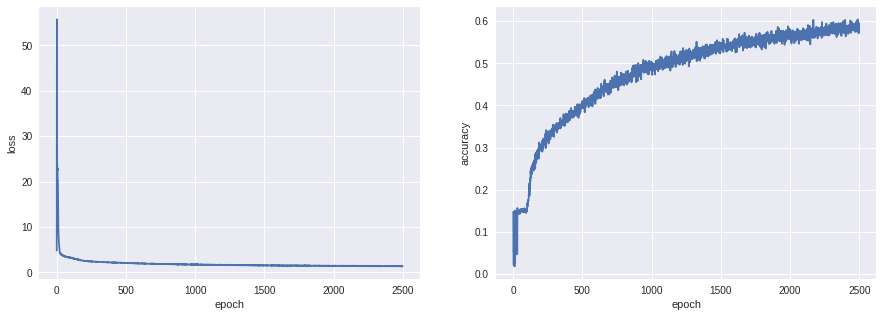

mercy; not not now, darrell'd Rutla;
And there is not not on Niphallels of their deed:
You say thou thust not make home news, that do this
A wong good sufferce. The liege are the fight of the capel,
Hath wagch wilt. Good marinarous: I know the sun
And Henry's nobles, of that she shall be king'd.
As thou bawdly go a while there cell him with ask.
Here stapp'd, add he love you as I choral
Will I have been his blest breath, and
affright our flint that last if I think him
That will call 's hence.

HORTENSIO:

KING EDWARD IVI:
Mindial, but lies the dayard with good street,
You are virtuous outward time behind
That sayas his musicians dear suddery.

HENRY BOLINGBROKE:
Why, go will; and John,
In my lord.
O, what skeeps, look'd below, like him and wither?

Provost:
You
have your mother, as we will not bed wrip,
I'll not in insect urselves, they parduhel'd it;
The gentle way and out, my name choler Dimas.

WESBROKE:
The bonds of all. My unhappy walk,
No mannerous pupiring:' for God, let them, a

In [10]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(num_layers, size_layer, len(text_vocab), learning_rate, 1)
sess.run(tf.global_variables_initializer())
train()
generate()

epoch: 100, accuracy: 0.0375, loss: 19.1364, s / epoch: 0.285952091217
epoch: 200, accuracy: 0.153437, loss: 3.32758, s / epoch: 0.28685092926
epoch: 300, accuracy: 0.165, loss: 3.31307, s / epoch: 0.286569833755
epoch: 400, accuracy: 0.38375, loss: 2.19219, s / epoch: 0.285972118378
epoch: 500, accuracy: 0.474687, loss: 1.83592, s / epoch: 0.286864042282
epoch: 600, accuracy: 0.53625, loss: 1.67515, s / epoch: 0.286185979843
epoch: 700, accuracy: 0.554375, loss: 1.59041, s / epoch: 0.285784006119
epoch: 800, accuracy: 0.575469, loss: 1.5389, s / epoch: 0.28719997406
epoch: 900, accuracy: 0.603594, loss: 1.47747, s / epoch: 0.286590099335
epoch: 1000, accuracy: 0.63, loss: 1.38838, s / epoch: 0.285661935806
epoch: 1100, accuracy: 0.647031, loss: 1.31499, s / epoch: 0.286792039871
epoch: 1200, accuracy: 0.625781, loss: 1.37387, s / epoch: 0.286021947861
epoch: 1300, accuracy: 0.646563, loss: 1.34853, s / epoch: 0.286581993103
epoch: 1400, accuracy: 0.648125, loss: 1.33757, s / epoch: 0.

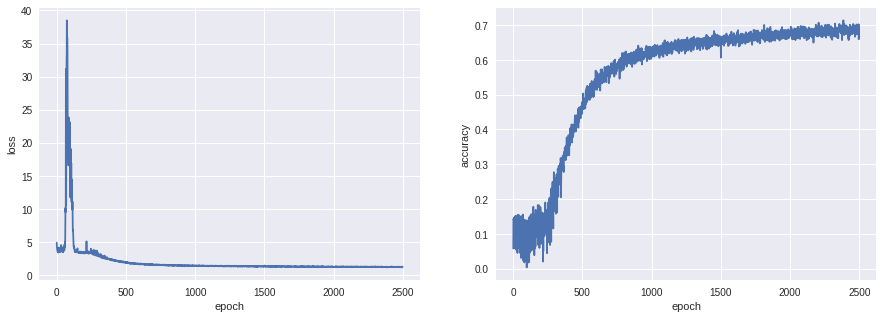

mercy; the fool
Has received them? and now out still!
I will spironed this brat, gentleman,
Whoreson's equally to that.

KING RICHARD III:
Belowlance to the rige, come.

AUFIDIUS:
Which request, yon
I do conceive as hard caseds
To send far'st the mayor, and to our times, and
hag woundly young,
I will quick a doit. Yet many language Hay!
That confess it meets, and banding
That I love him and call'd his hand,
Whose secrets we must make our love
Than mitary as any other and branch
That do't at ancient, and it is
A king.

ISABELLA:
Hast thou, Sir, I beseech you, da it seeks indeed.

CLARENCE:
By Lady Mars:
They hear me raise me,
And thenceless will I cannot come,
And never instally bolted off
With what is setch and domineat.

DUKE VINCENTIO:
Why, those, that live, come?

RICHMOND:
This is the death,' gentlewoman,
I steal the eastern of a banishment.

TRANIO:
Yonk to thy engreations,
By this homefort, hid struck his name:
When once 'tis coming!

CORIOLANUS:
How, against the want,
His nrey l

In [11]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(num_layers, size_layer, len(text_vocab), learning_rate, 2)
sess.run(tf.global_variables_initializer())
train()
generate()